In [1]:
import sys
sys.path.append('python/')

import time
startTime = time.time()

import numpy as np
import matplotlib.pyplot as plt 
import load_galaxies as lg
import matplotlib.image as mpimg
import lmfit as lm

## Import data

In [2]:
galaxy = lg.NGC5533                  # Change this value to select which galaxy you want

# Measured data
measured_data = galaxy['measured_data']

# Separate the columns into arrays
m_radii = galaxy['m_radii']
m_velocities = galaxy['m_velocities']
m_r_errors = galaxy['m_r_errors']
m_v_errors = galaxy['m_v_errors']    # Errors in velocity

# Central black hole
massbh = 2.7e9                      # Mass of the central black hole in (solar mass)
G = 4.300e-6                        # Gravitational constant (kpc/solar mass*(km/s)^2)
def blackhole_v(r,massbh):
    return np.sqrt((G*massbh)/r)

# Bulge
bulge_v = galaxy['bulge']['spline']
# Disk
disk_v = galaxy['disk']['spline']
# Gas
gas_v = galaxy['gas']['spline']
# Dark matter halo
halo_v = galaxy['halo']['spline']
# Total velocity
total_v = galaxy['total']['spline']

## Define some values

In [3]:
# Express weight
weighdata = 1/m_v_errors

# Define function for total velocity with prefactors
def total_v_pref(r,massbh,bpref,dpref,gpref,hpref):
    return np.sqrt(blackhole_v(r,massbh)**2
                   + (bpref*bulge_v(r))**2 
                   + (dpref*disk_v(r))**2 
                   + (gpref*gas_v(r))**2
                   + (hpref*halo_v(r))**2)

## Fitting parameters

In [4]:
# Setup
f_mod = lm.Model(total_v_pref)
f_params = f_mod.make_params()

# Halo
f_params.add('hpref',    vary=True,    value=1,   min=0.1)      # halo prefactor
#f_params.add('rc',      vary=True,     value=rc,   min=0.1)         # core radius (kpc)
#f_params.add('rho0',    vary=True,     value=rho0, min=0)           # central halo density (units)

# Black Hole
f_params.add('massbh',  vary=False,    value=massbh, min=1.0e8)   # mass of central black hole

# Bulge
f_params.add('bpref',   vary=False,    value=1,   min=0,max=100)  # bulge prefactor

# Disk
f_params.add('dpref',   vary=False,    value=1,   min=0,max=100)  # disk prefactor

# Gas
f_params.add('gpref',   vary=False,    value=1,   min=.8,max=1.2) # gas prefactor

## Do the fitting

In [10]:
f_fit = f_mod.fit(m_velocities,f_params,r=m_radii,weights=weighdata)

# Show fit statistics
f_fit

## Define parameters for plotting

In [6]:
bestf = f_fit.best_fit

# Radius
r = np.linspace(0.01,100,100)        # starting from zero results in a divide by zero error

f_dict = f_fit.best_values
f_hpref = f_dict['hpref']
#f_rc = f_dict['rc']
#f_rho0 = f_dict['rho0']
f_massbh = f_dict['massbh']
f_bpref = f_dict['bpref']
f_dpref = f_dict['dpref']
f_gpref = f_dict['gpref']

f_curve = total_v_pref(r,f_massbh,f_bpref,f_dpref,f_gpref,f_hpref)

## Plot result

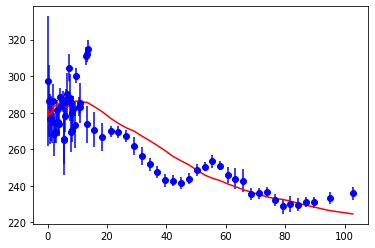

In [7]:
plt.errorbar(m_radii,m_velocities,yerr=m_v_errors,fmt='bo')
plt.plot(m_radii,bestf,'r-')

## Calculate the total mass of the dark matter (bonus)

In [8]:
# Equation for isothermal density

# Equation for mass as a function of radius

# Total mass


In [9]:
# Time
executionTime = (time.time() - startTime)
ttt=executionTime/60
print(f'Execution time: {ttt:.2f} minutes')

Execution time: 0.02 minutes


# References <br>
>Casertano, Stefano. __"Rotation curve of the edge-on spiral galaxy NGC 5907: disc and halo masses."__ _Monthly Notices of the Royal Astronomical Society_ 203, no. 3 (1983): 735-747.<br><br>
>Jimenez, Raul, Licia Verde, and S. Peng Oh. __"Dark halo properties from rotation curves."__ _Monthly Notices of the Royal Astronomical Society_ 339, no. 1 (2003): 243-259.<br><br>
>Karukes, E. V., P. Salucci, and Gianfranco Gentile. __"The dark matter distribution in the spiral NGC 3198 out to 0.22 $R_{vir}$."__ _Astronomy & Astrophysics_ 578 (2015): A13.<br><br>
>Noordermeer, Edo. __"The rotation curves of flattened Sérsic bulges."__ _Monthly Notices of the Royal Astronomical Society_ 385, no. 3 (2007): 1359-1364.
***